# Deep Learning - Melanoma - V2

Plan:
- [X] clean csv and get a proper csv with image file name, label
- [X] get photos into image net format
    - training dataset
    - validation dataset - the folder structure to later be used
- apply basic resnet learner
- start modifying data for unbalanced dataset
    - SMOTE? oversampling? 5 fold cross validation
- apply resnet + training
- add optimizations
- test predictions & results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import pandas as pd
import numpy as np
import seaborn as sns
import shutil
import os

In [3]:
! pwd

/home/luis/code-projects/dl-melanoma-env/dl-melanoma-env-2


In [4]:
currPathStr = '/home/luis/code-projects/dl-melanoma-env/dl-melanoma-env-2'
currPath = Path('/home/luis/code-projects/dl-melanoma-env/dl-melanoma-env-2')
print(currPath)

/home/luis/code-projects/dl-melanoma-env/dl-melanoma-env-2


## Create clean csv

In [5]:
groundTruthDf = pd.read_csv('ISIC2018_Task3_Training_GroundTruth.csv')
groundTruthDf.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# given the csv label dataframe, it will return a new dataframe with two columns
# col1 = image: contains the image name
# col2 = classification: contains the abbreviated classification
def createNewLabelDataframe(df):
    imageNames = df['image'].values.tolist()
    for i in range(len(imageNames)):
        imageNames[i] = imageNames[i] + ".jpg"
    classLabels = df.columns[1:].tolist()
    (rowNum, colNum) = df.shape
    labelArray = []
    for i in range(0, rowNum):
        # find the index of the max
        maxIndex = np.argmax(df.iloc[i, 1:].values)
        # get the label of that index
        tempClassLabel  = classLabels[maxIndex]
        # append it to labelArray
        labelArray.append(tempClassLabel)
    labelArray = np.array(labelArray)
#     print(imageNames[0:5])
#     print(labelArray[0:5])
    outputDf = pd.DataFrame({'image_filename':imageNames, 'label':labelArray})
    return outputDf

In [7]:
newLabelsDf = createNewLabelDataframe(groundTruthDf)
newLabelsDf.head()

,image_filename,label
0,ISIC_0024306.jpg,NV
1,ISIC_0024307.jpg,NV
2,ISIC_0024308.jpg,NV
3,ISIC_0024309.jpg,NV
4,ISIC_0024310.jpg,MEL


In [8]:
newLabelsDf.to_csv(currPathStr + "/csv_labels.csv", index=False)

## Create folders for image classes

In [69]:
def reinitCleanData(cleanDataPath):
    classLabels = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
    if os.path.exists(cleanDataPath):
        shutil.rmtree(cleanDataPath)
        print("Removed pre-existing ", cleanDataPath)
    trainDatasetPath = Path(cleanDataPath + 'train/skin_cancer')
    trainDatasetPathStr = str(trainDatasetPath)
    trainDatasetPath.mkdir(parents=True, exist_ok=True)

    validDatasetPath = Path(cleanDataPath + 'valid/skin_cancer')
    validDatasetPathStr = str(validDatasetPath)
    validDatasetPath.mkdir(parents=True, exist_ok=True)
    for i in classLabels:
        dest1 = trainDatasetPath/i
        dest1.mkdir(parents=True, exist_ok=True)
        dest2 = validDatasetPath/i
        dest2.mkdir(parents=True, exist_ok=True)

In [9]:
# clear an existing clean_data dir if it exists
if os.path.exists("clean_data"):
    shutil.rmtree("clean_data")
    print("Removed pre-existing clean_data dir")

Removed pre-existing clean_data dir


In [10]:
classLabels = groundTruthDf.columns[1:].tolist()
classLabels

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [11]:
trainDatasetPath = Path('clean_data/train/skin_cancer')
trainDatasetPathStr = str(trainDatasetPath)
trainDatasetPath.mkdir(parents=True, exist_ok=True)

validDatasetPath = Path('clean_data/valid/skin_cancer')
validDatasetPathStr = str(validDatasetPath)
validDatasetPath.mkdir(parents=True, exist_ok=True)

In [12]:
! ls -la {trainDatasetPath}

total 8
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 .
drwxrwxr-x 3 luis luis 4096 Apr  4 01:28 ..


In [13]:
! ls -la {validDatasetPath}

total 8
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 .
drwxrwxr-x 3 luis luis 4096 Apr  4 01:28 ..


In [14]:
for i in classLabels:
    dest1 = trainDatasetPath/i
    dest1.mkdir(parents=True, exist_ok=True)
    dest2 = validDatasetPath/i
    dest2.mkdir(parents=True, exist_ok=True)

In [15]:
! ls -la {trainDatasetPath}

total 36
drwxrwxr-x 9 luis luis 4096 Apr  4 01:28 .
drwxrwxr-x 3 luis luis 4096 Apr  4 01:28 ..
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 AKIEC
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 BCC
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 BKL
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 DF
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 MEL
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 NV
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 VASC


In [16]:
! ls -la {validDatasetPath}

total 36
drwxrwxr-x 9 luis luis 4096 Apr  4 01:28 .
drwxrwxr-x 3 luis luis 4096 Apr  4 01:28 ..
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 AKIEC
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 BCC
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 BKL
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 DF
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 MEL
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 NV
drwxrwxr-x 2 luis luis 4096 Apr  4 01:28 VASC


In [17]:
# the following function will take a path of images and split them into their proper labels
# into the destination folder
# based on a certain labelled csv

# imagesPath = "./data/train/"
# cleanDataPath = "./clean_data/train/"
# labelledCsvPath = "csv_labels.csv"
def imageNetFormat(imagesPath, cleanDataPath, labelledCsvPath):
    csvDf = pd.read_csv(labelledCsvPath)
    (rowNum, colNum) = csvDf.shape
    for i in range(0, rowNum):
        imageName = csvDf.iloc[i,0]
        imageLabel = csvDf.iloc[i,1]
#         print(imageName)
#         print(imageLabel)
        imagePath = imagesPath + imageName
        newImagePath = cleanDataPath + imageLabel + "/" + imageName
#         print(imagePath)
#         print(newImagePath)
        shutil.copy(imagePath, newImagePath)
    print("Done copying files from " + imagesPath + " into " + cleanDataPath)

## Move the files into imagenet format

In [18]:
# training dataset
imagesPath = "./data/train/"
cleanDataPath = "./clean_data/train/skin_cancer/"
labelledCsvPath = "./csv_labels.csv"
imageNetFormat(imagesPath, cleanDataPath, labelledCsvPath)

Done copying files from ./data/train/ into ./clean_data/train/skin_cancer/


## Dataset Inspection

In [19]:
trainingDf = pd.read_csv("./csv_labels.csv")
trainingDf.head()

,image_filename,label
0,ISIC_0024306.jpg,NV
1,ISIC_0024307.jpg,NV
2,ISIC_0024308.jpg,NV
3,ISIC_0024309.jpg,NV
4,ISIC_0024310.jpg,MEL


In [20]:
trainingDf.shape

(10015, 2)

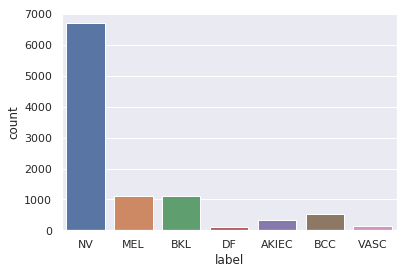

In [21]:
sns.set(style="darkgrid")
ax = sns.countplot(x="label", data=trainingDf)

In [22]:
trainingDf['label'].value_counts()

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64

In [23]:
trainingDf['label'].value_counts(normalize=True)

NV       0.669496
MEL      0.111133
BKL      0.109735
BCC      0.051323
AKIEC    0.032651
VASC     0.014179
DF       0.011483
Name: label, dtype: float64

## Dataset Using New ImageSet Format

In [24]:
np.random.seed(42)
cleanDataPath = "./clean_data"
data = ImageDataBunch.from_folder(cleanDataPath, train="./train/skin_cancer/", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [25]:
data.classes

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

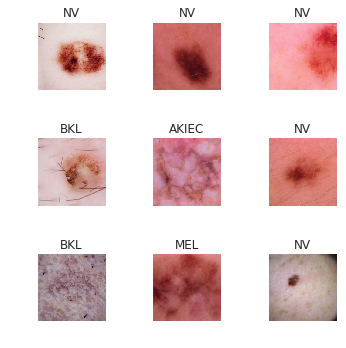

In [26]:
data.show_batch(rows=3, figsize=(5,5), ds_type=DatasetType.Train)

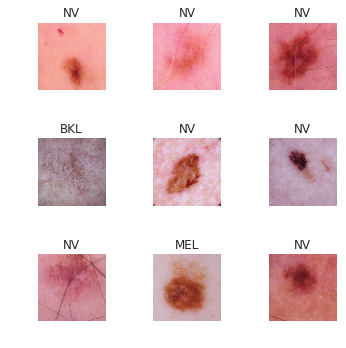

In [27]:
data.show_batch(rows=3, figsize=(5,5), ds_type=DatasetType.Valid)

In [28]:
print("Data classes = ", data.classes)
print("Number of data classes/labels = ", data.c)
print("Number of training dataset", len(data.train_ds))
print("Number of validation dataset", len(data.valid_ds))

Data classes =  ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
Number of data classes/labels =  7
Number of training dataset 8012
Number of validation dataset 2003


## Naive Model

In [29]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [30]:
learn.metrics=[accuracy,
               Precision(average='micro'),
               Recall(average='micro'),
               FBeta(average='micro'),
               error_rate]

In [31]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,error_rate,time
1,1.259840,0.709736,0.757364,nan,0.757364,nan,0.242636,01:24
2,0.777499,0.613252,0.778332,nan,0.778332,nan,0.221667,01:25
3,0.660963,0.551692,0.796805,0.796805,0.796805,0.796805,0.203195,01:25
4,0.599583,0.527260,0.806790,0.806790,0.806790,0.806790,0.193210,01:27
5,0.556175,0.519381,0.811283,0.811283,0.811283,0.811283,0.188717,01:26


In [32]:
learn.save('stage-1-naive-04-more-metric')

In [33]:
learn.unfreeze()

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


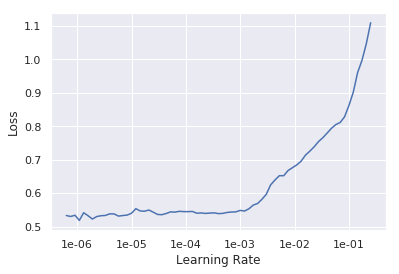

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,error_rate,time
1,0.685497,0.827806,0.720919,0.720919,0.720919,0.720919,0.279081,01:27
2,0.514854,0.425061,0.843235,0.843235,0.843235,0.843235,0.156765,01:26


In [37]:
learn.save('stage-1-naive-05')

### Interpretation

In [38]:
learn.load('stage-1-naive-05');

In [39]:
interp = ClassificationInterpretation.from_learner(learn)

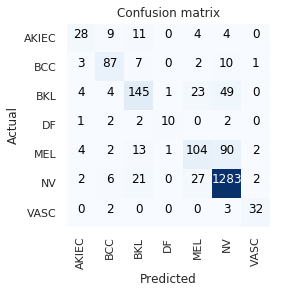

In [40]:
interp.plot_confusion_matrix()

Considering the fact that NV makes up 67% of the dataset and the model has an accuracy of about 80%, this means that the imbalance in the dataset is playing a role and producing deceiving accuracy.

I also want to know how well I can specifically classify each class. In statistics, this is called recall, and it’s the number of correctly predicted “positives” divided by the total number of “positives”.

## Attempt \#1 to Fix Imbalance - Random Undersampling

In [42]:
trainingDf2 = pd.read_csv("./csv_labels.csv")
trainingDf2.head()

,image_filename,label
0,ISIC_0024306.jpg,NV
1,ISIC_0024307.jpg,NV
2,ISIC_0024308.jpg,NV
3,ISIC_0024309.jpg,NV
4,ISIC_0024310.jpg,MEL


In [46]:
trainingDf2.label.value_counts()

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64

In [52]:
# class count = cc
cc_nv, cc_mel, cc_bkl, cc_bcc, cc_akiec, cc_vasc, cc_df = trainingDf2.label.value_counts()
print(cc_nv, cc_mel, cc_bkl, cc_bcc, cc_akiec, cc_vasc, cc_df)

6705 1113 1099 514 327 142 115


In [50]:
# divide by class
df_class_nv = trainingDf2[trainingDf2['label'] == 'NV']
print(df_class_nv.head())
df_class_mel = trainingDf2[trainingDf2['label'] == 'MEL']
print(df_class_mel.head())
df_class_bkl = trainingDf2[trainingDf2['label'] == 'BKL']
print(df_class_bkl.head())
df_class_bcc = trainingDf2[trainingDf2['label'] == 'BCC']
print(df_class_bcc.head())
df_class_akiec = trainingDf2[trainingDf2['label'] == 'AKIEC']
print(df_class_akiec.head())
df_class_vasc = trainingDf2[trainingDf2['label'] == 'VASC']
print(df_class_vasc.head())
df_class_df = trainingDf2[trainingDf2['label'] == 'DF']
print(df_class_df.head())

     image_filename label
0  ISIC_0024306.jpg    NV
1  ISIC_0024307.jpg    NV
2  ISIC_0024308.jpg    NV
3  ISIC_0024309.jpg    NV
5  ISIC_0024311.jpg    NV
      image_filename label
4   ISIC_0024310.jpg   MEL
7   ISIC_0024313.jpg   MEL
9   ISIC_0024315.jpg   MEL
17  ISIC_0024323.jpg   MEL
27  ISIC_0024333.jpg   MEL
      image_filename label
6   ISIC_0024312.jpg   BKL
18  ISIC_0024324.jpg   BKL
30  ISIC_0024336.jpg   BKL
31  ISIC_0024337.jpg   BKL
32  ISIC_0024338.jpg   BKL
      image_filename label
25  ISIC_0024331.jpg   BCC
26  ISIC_0024332.jpg   BCC
39  ISIC_0024345.jpg   BCC
54  ISIC_0024360.jpg   BCC
97  ISIC_0024403.jpg   BCC
       image_filename  label
23   ISIC_0024329.jpg  AKIEC
66   ISIC_0024372.jpg  AKIEC
112  ISIC_0024418.jpg  AKIEC
144  ISIC_0024450.jpg  AKIEC
157  ISIC_0024463.jpg  AKIEC
       image_filename label
64   ISIC_0024370.jpg  VASC
69   ISIC_0024375.jpg  VASC
96   ISIC_0024402.jpg  VASC
169  ISIC_0024475.jpg  VASC
356  ISIC_0024662.jpg  VASC
       image_fil

In [65]:
# making number of sample of largest class (nv) the same size as the second biggest class
df_class_nv_under = df_class_nv.sample(cc_mel)
print(df_class_nv_under.shape)
new_df_under = pd.concat([df_class_nv_under, df_class_mel, df_class_bkl, df_class_bcc, df_class_akiec, df_class_vasc, df_class_df], axis=0)

(1113, 2)


Before under-sampling:
NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64
NV       0.669496
MEL      0.111133
BKL      0.109735
BCC      0.051323
AKIEC    0.032651
VASC     0.014179
DF       0.011483
Name: label, dtype: float64


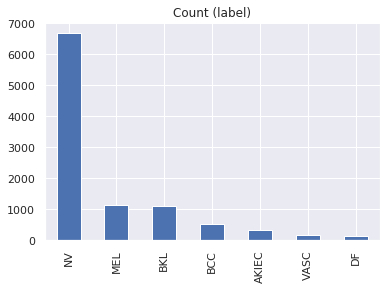

In [88]:
print('Before under-sampling:')
print(trainingDf2.label.value_counts())
print(trainingDf2['label'].value_counts(normalize=True))
trainingDf2.label.value_counts().plot(kind='bar', title='Count (label)');

Random under-sampling:
NV       1113
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64
NV       0.251639
MEL      0.251639
BKL      0.248474
BCC      0.116211
AKIEC    0.073932
VASC     0.032105
DF       0.026000
Name: label, dtype: float64


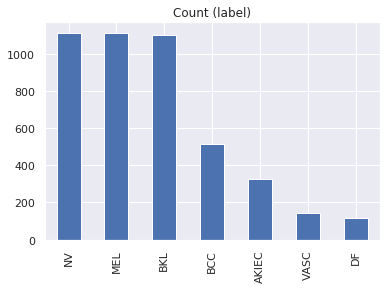

In [89]:
print('Random under-sampling:')
print(new_df_under.label.value_counts())
print(new_df_under['label'].value_counts(normalize=True))
new_df_under.label.value_counts().plot(kind='bar', title='Count (label)');

In [67]:
def imageNetFormatDf(imagesPath, cleanDataPath, csvDf):
    (rowNum, colNum) = csvDf.shape
    for i in range(0, rowNum):
        imageName = csvDf.iloc[i,0]
        imageLabel = csvDf.iloc[i,1]
#         print(imageName)
#         print(imageLabel)
        imagePath = imagesPath + imageName
        newImagePath = cleanDataPath + imageLabel + "/" + imageName
#         print(imagePath)
#         print(newImagePath)
        shutil.copy(imagePath, newImagePath)
    print("Done copying files from " + imagesPath + " into " + cleanDataPath)

In [72]:
# training dataset
reinitCleanData("clean_data2/")
imagesPath = "./data/train/"
cleanDataPath = "./clean_data2/train/skin_cancer/"
imageNetFormatDf(imagesPath, cleanDataPath, new_df_under)

Removed pre-existing  clean_data2/
Done copying files from ./data/train/ into ./clean_data2/train/skin_cancer/


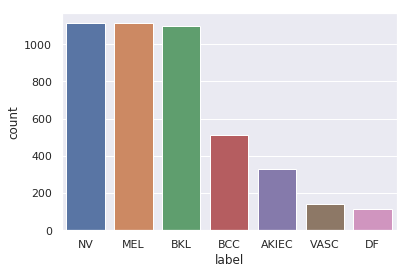

In [73]:
sns.set(style="darkgrid")
ax = sns.countplot(x="label", data=new_df_under)

In [76]:
np.random.seed(42)
cleanDataPath2 = "./clean_data2"
data2 = ImageDataBunch.from_folder(cleanDataPath2, train="./train/skin_cancer/", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
print("Data classes = ", data2.classes)
print("Number of data classes/labels = ", data2.c)
print("Number of training dataset", len(data2.train_ds))
print("Number of validation dataset", len(data2.valid_ds))

Data classes =  ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
Number of data classes/labels =  7
Number of training dataset 3539
Number of validation dataset 884


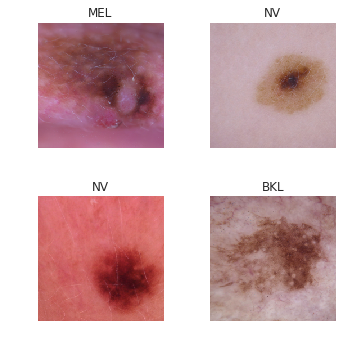

In [83]:
data2.show_batch(rows=2, figsize=(5,5), ds_type=DatasetType.Train)

In [ ]:
# learn2 = create_cnn(data2, models.resnet34, metrics=error_rate)
# learn2.metrics=[accuracy,
#                Precision(average='micro'),
#                Recall(average='micro'),
#                FBeta(average='micro'),
#                error_rate]
# learn2.fit_one_cycle(5)

# learn2.save('stage-2-01')
# learn2.unfreeze()
# learn2.lr_find()
# learn2.recorder.plot()

# learn2.fit_one_cycle(2, max_lr=slice(1e-4,1e-2))
# learn2.save('stage-2-02')

# learn2.load('stage-2-02');
# interp2 = ClassificationInterpretation.from_learner(learn2)
# interp2.plot_confusion_matrix()

In [77]:
learn2 = create_cnn(data2, models.resnet34, metrics=error_rate)
learn2.metrics=[accuracy,
               Precision(average='micro'),
               Recall(average='micro'),
               FBeta(average='micro'),
               error_rate]
learn2.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,error_rate,time
1,1.768078,1.191336,0.583710,0.583710,0.583710,0.583710,0.416290,00:38
2,1.349244,0.982479,0.631222,0.631222,0.631222,0.631222,0.368778,00:38
3,1.118612,0.916125,0.657240,0.657240,0.657240,0.657240,0.342760,00:38
4,0.982961,0.870073,0.668552,0.668552,0.668552,0.668552,0.331448,00:37
5,0.906363,0.861230,0.666290,0.666290,0.666290,0.666290,0.333710,00:39


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


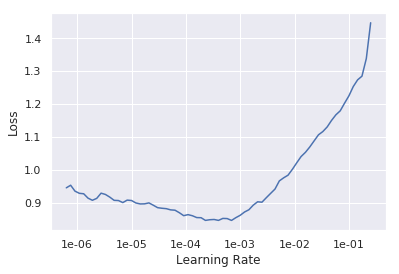

In [78]:
learn2.save('stage-2-01')
learn2.unfreeze()
learn2.lr_find()
learn2.recorder.plot()

In [85]:
learn2.fit_one_cycle(5, max_lr=slice(1e-4,1e-2))
learn2.save('stage-2-02')

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,error_rate,time
1,0.720729,1.005482,0.661765,0.661765,0.661765,0.661765,0.338235,00:39
2,0.743353,0.814821,0.697964,0.697964,0.697964,0.697964,0.302036,00:38
3,0.664146,0.724986,0.738688,0.738688,0.738688,0.738688,0.261312,00:38
4,0.545426,0.604580,0.792986,0.792986,0.792986,0.792987,0.207014,00:38
5,0.411399,0.607457,0.790724,0.790724,0.790724,0.790724,0.209276,00:38


- If your training loss is much lower than validation loss then this means the network might be overfitting
    - Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on
- If your training/validation loss are about equal then your model is underfitting. 
    - Increase the size of your model (either number of layers or the raw number of neurons per layer)

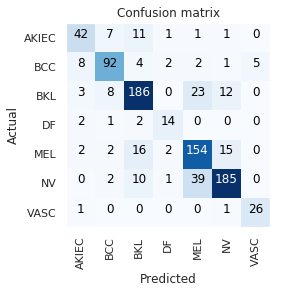

In [86]:
learn2.load('stage-2-02');
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix()

In [98]:
#most confused
interp2.most_confused(min_val=10)

[('NV', 'MEL', 39),
 ('BKL', 'MEL', 23),
 ('MEL', 'BKL', 16),
 ('MEL', 'NV', 15),
 ('BKL', 'NV', 12),
 ('AKIEC', 'BKL', 11),
 ('NV', 'BKL', 10)]

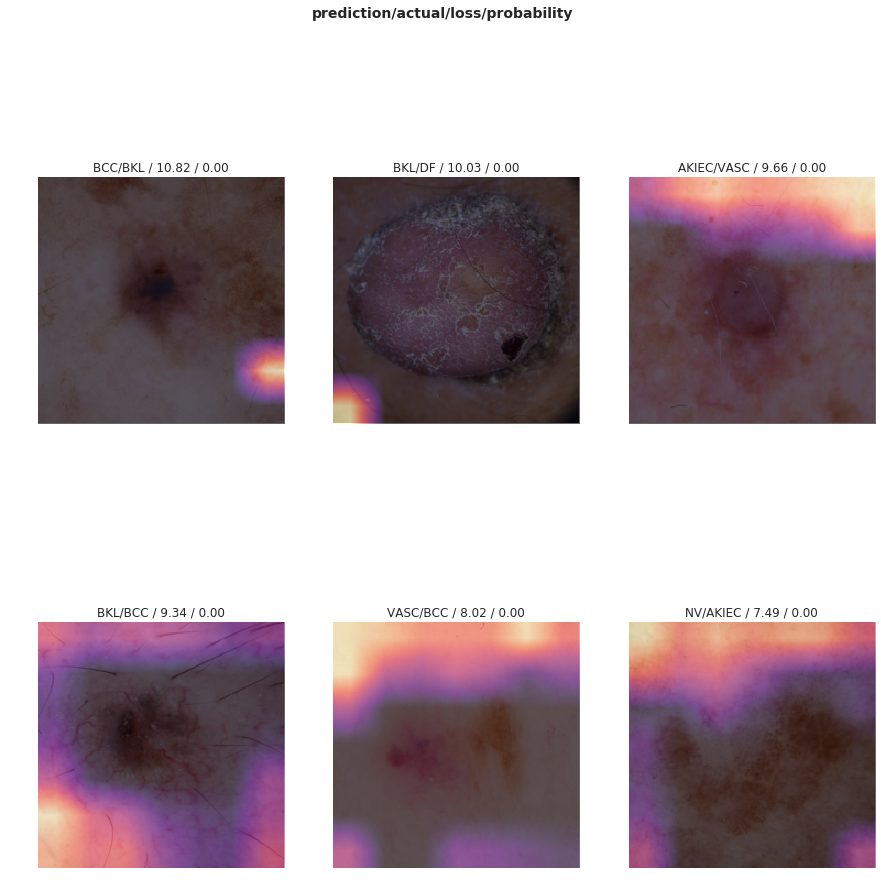

In [87]:
interp2.plot_top_losses(6, figsize=(15,15))

## Improvement \#2

Now that I have improved the model through cleaning the entry data more (undersampling) thereby better representing reality.

I will now try to through more horsepower at the system. 

In [101]:
# using new df
print(new_df_under.head())
print(new_df_under.shape)

# at this stage could use another version of new_df_under, but for now keeping the same for consistenct in testing

# training dataset
reinitCleanData("clean_data3/")
imagesPath = "./data/train/"
cleanDataPath3 = "./clean_data3/train/skin_cancer/"
imageNetFormatDf(imagesPath, cleanDataPath, new_df_under)

        image_filename label
1289  ISIC_0025595.jpg    NV
3954  ISIC_0028260.jpg    NV
9695  ISIC_0034001.jpg    NV
8394  ISIC_0032700.jpg    NV
9785  ISIC_0034091.jpg    NV
(4423, 2)
Removed pre-existing  clean_data3/
Done copying files from ./data/train/ into ./clean_data3/train/skin_cancer/


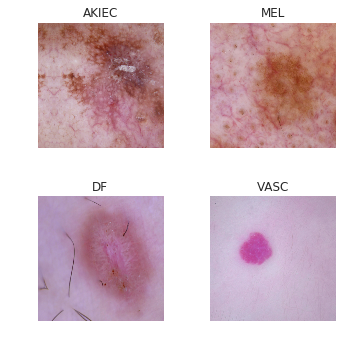

In [104]:
bs = 24
# I want all the transforms I can get. none of these things really matter with a scope.
data3 = ImageDataBunch.from_folder(cleanDataPath3, train="./train/skin_cancer/", valid_pct=0.2, ds_tfms=get_transforms(do_flip=True, flip_vert=True, max_lighting=0.2, max_rotate=359, 
                                                              max_zoom=1.05, max_warp=0.2), size=500, bs=bs//4).normalize(imagenet_stats)
data3.show_batch(rows=2, figsize=(5,5), ds_type=DatasetType.Train)

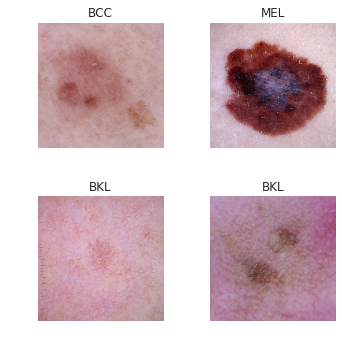

In [106]:
data3.show_batch(rows=2, figsize=(5,5), ds_type=DatasetType.Valid)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


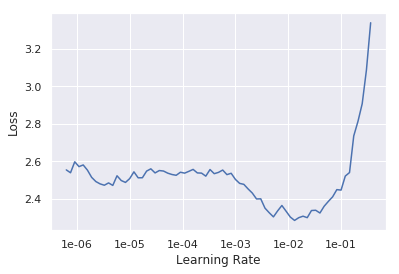

In [107]:
learn3 = create_cnn(data3, models.resnet50, metrics=error_rate)
learn3.metrics=[accuracy,
               Precision(average='micro'),
               Recall(average='micro'),
               FBeta(average='micro'),
               error_rate]
learn3.lr_find()
learn3.recorder.plot()

In [108]:
learn3.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,error_rate,time
1,1.444556,1.180815,0.557692,0.557692,0.557692,0.557692,0.442308,01:41
2,1.398260,1.000739,0.615385,0.615385,0.615385,0.615385,0.384615,01:40
3,1.189993,0.829702,0.679864,0.679864,0.679864,0.679864,0.320136,01:40
4,0.969442,0.754469,0.696833,0.696833,0.696833,0.696833,0.303167,01:40
5,0.924653,0.741963,0.714932,0.714932,0.714932,0.714932,0.285068,01:40
6,0.889562,0.702518,0.734163,0.734163,0.734163,0.734163,0.265837,01:40
7,0.930850,0.712636,0.740950,0.740950,0.740950,0.740950,0.259050,01:40
8,0.802358,0.663187,0.744344,0.744344,0.744344,0.744344,0.255656,01:40


In [109]:
learn3.save('stage-3-resnet50-01')

In [110]:
learn3.unfreeze()
learn3.fit_one_cycle(8, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,error_rate,time
1,0.834854,0.670404,0.736425,0.736425,0.736425,0.736425,0.263575,02:08
2,0.901130,0.727035,0.720588,0.720588,0.720588,0.720588,0.279412,02:07
3,0.835709,0.640609,0.754525,0.754525,0.754525,0.754525,0.245475,02:07
4,0.885948,0.679910,0.750000,0.750000,0.750000,0.750000,0.250000,02:07
5,0.777532,0.586955,0.773756,0.773756,0.773756,0.773756,0.226244,02:08
6,0.653972,0.602913,0.785068,0.785068,0.785068,0.785068,0.214932,02:08
7,0.665046,0.571021,0.791855,0.791855,0.791855,0.791855,0.208145,02:08
8,0.673514,0.561247,0.789593,0.789593,0.789593,0.789593,0.210407,02:08


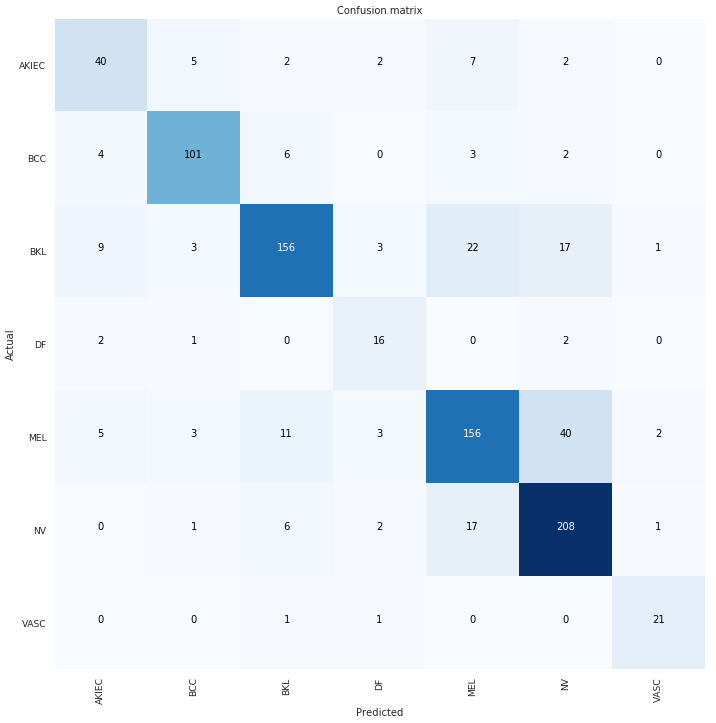

In [111]:
learn3.save('stage-3-resnet50-02')
learn3.load('stage-3-resnet50-02')
interp3 = ClassificationInterpretation.from_learner(learn3)
interp3.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [112]:
interp3.most_confused(min_val=10)

[('MEL', 'NV', 40),
 ('BKL', 'MEL', 22),
 ('BKL', 'NV', 17),
 ('NV', 'MEL', 17),
 ('MEL', 'BKL', 11)]

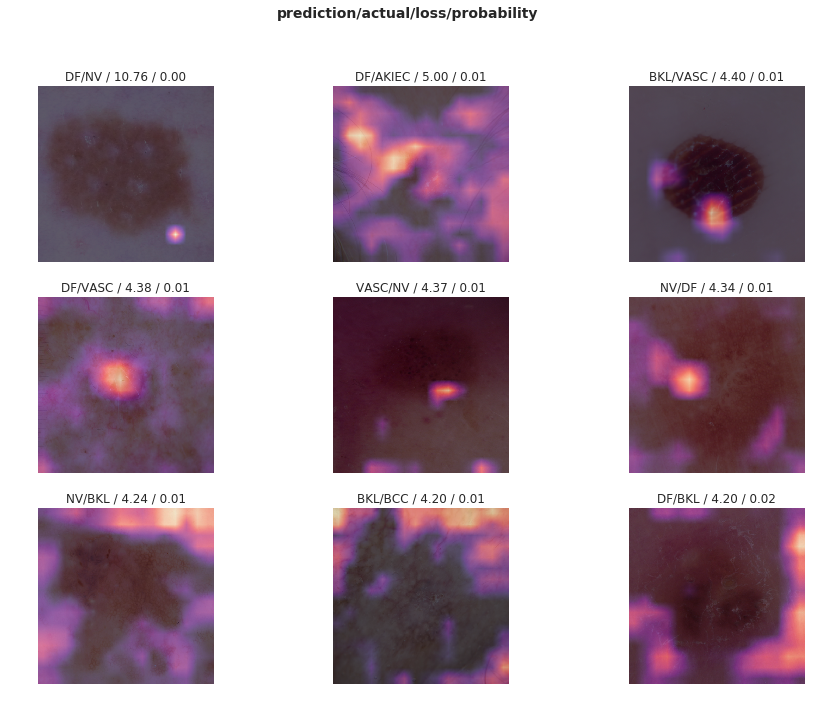

In [113]:
interp3.plot_top_losses(9, figsize=(15,11))